In [1]:
import os
import numpy as np
import pandas as pd
from numpy.linalg import svd
import matplotlib.pyplot as plt
from IPython.display import clear_output

###
import utils.dhs_config as dhs_config
import utils.dhs_utils as dhs
from utils.ot import *

## Data

In [9]:
# Main folder with respect from the scripts
MAIN = "../"

# Data folder
DATA = os.path.join(MAIN, "data")

# Raw data folder (where .sav files are)
RAW_DATA = os.path.join(DATA, "raw")

# Transformed data folder
TRS_DATA = os.path.join(DATA, "transformed")

column_variables, column_others = dhs_config.get_columns()

if not(os.path.exists(os.path.join(TRS_DATA, 'df_all.csv'))):
    df_all, couple_all = dhs.get_all_data(RAW_DATA,
                                          column_variables + column_others)
    
    # In year 1994 and 1996 there is some change in the psy question
    # so we skip thoses and also only take the variables of interest
    df_reduce = df_all[~df_all.year.isin([1994, 1996])][column_variables]
    couple_reduce = couple_all[~couple_all.year.isin([1994, 1996])]
    couple_clean = couple_reduce[couple_reduce.married == 1]

    # we clean the data and drop schooling as we did not have the time to clean it
    teg_dict, spaar_dict = dhs_config.get_dict()
    df_clean = df_reduce.replace(teg_dict).replace(spaar_dict).drop('scholing', axis=1)
    
    df_all.to_csv(os.path.join(TRS_DATA, 'df_all.csv'))
    couple_all.to_csv(os.path.join(TRS_DATA, 'couple_all.csv'))
    df_clean.to_csv(os.path.join(TRS_DATA, 'df_clean.csv'))
    couple_clean.to_csv(os.path.join(TRS_DATA, 'couple_clean.csv'))

else:
    df_clean = pd.read_csv(os.path.join(TRS_DATA, 'df_clean.csv'), index_col=0)
    couple_clean = pd.read_csv(os.path.join(TRS_DATA, 'couple_clean.csv'), index_col=0)

## Sinkhorn’s algorithm
$$
a\leftarrow \frac{\mu_1}{\int{b(y) e^{\Phi(x, y) / \sigma} dy}}
$$

$$
b\leftarrow \frac{\mu_2}{\int{a(x) e^{\Phi(x, y) / \sigma} dx}}
$$

$$
\Phi(x, y) = x^TAy
$$

## Distribution
$$
\pi^A(x, y) = a(x)b(y)e^{\Phi(x, y)/\sigma}
$$

## Proximal Gradient Descent
$$
A\leftarrow A - t\left( \sum_{i, j = 1}^N (\pi_{ij}^A - \hat{\pi}_{ij}) x^i (y^j)^T \right)
$$
$$
[U, S, V] = \text{SVD}(A)
$$
$$
A\leftarrow U \text{ diag}((s_0 - t\lambda)_+, ...(s_d - t\lambda)_+)V^T
$$

## Experiments

## Feature influence

In [96]:
A_all = {}
history_coefs_all = {}
history_grad_all = {} 

for i in range(1, 24):
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50, :i]
    Y = Y[:50, :i]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, verbose=False)
    A_all[i] = A
    history_coefs_all[i] = history_coefs
    history_grad_all[i] = history_grad

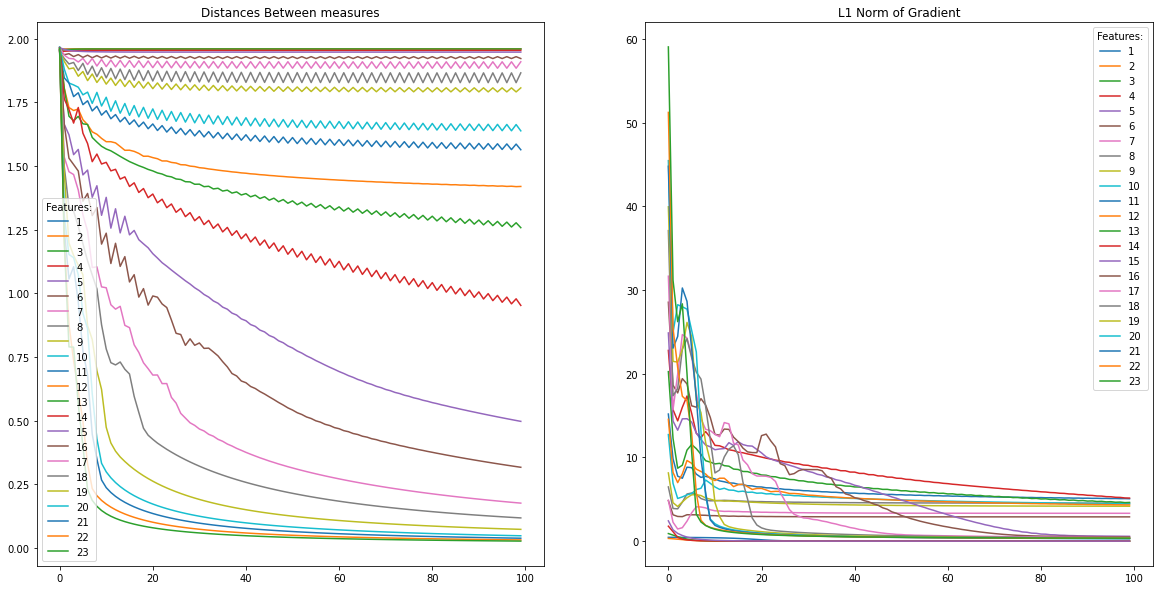

In [97]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")
ax.legend(title='Features:')

ax = plt.subplot(122)

for key, item in history_grad_all.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")
ax.legend(title='Features:')

plt.show()

In [98]:
A_all_svd = {}
history_coefs_all_svd = {}
history_grad_all_svd = {} 

for i in range(1, 24):
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50, :i]
    Y = Y[:50, :i]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, verbose=False, svd_flag=True)
    A_all_svd[i] = A
    history_coefs_all_svd[i] = history_coefs
    history_grad_all_svd[i] = history_grad

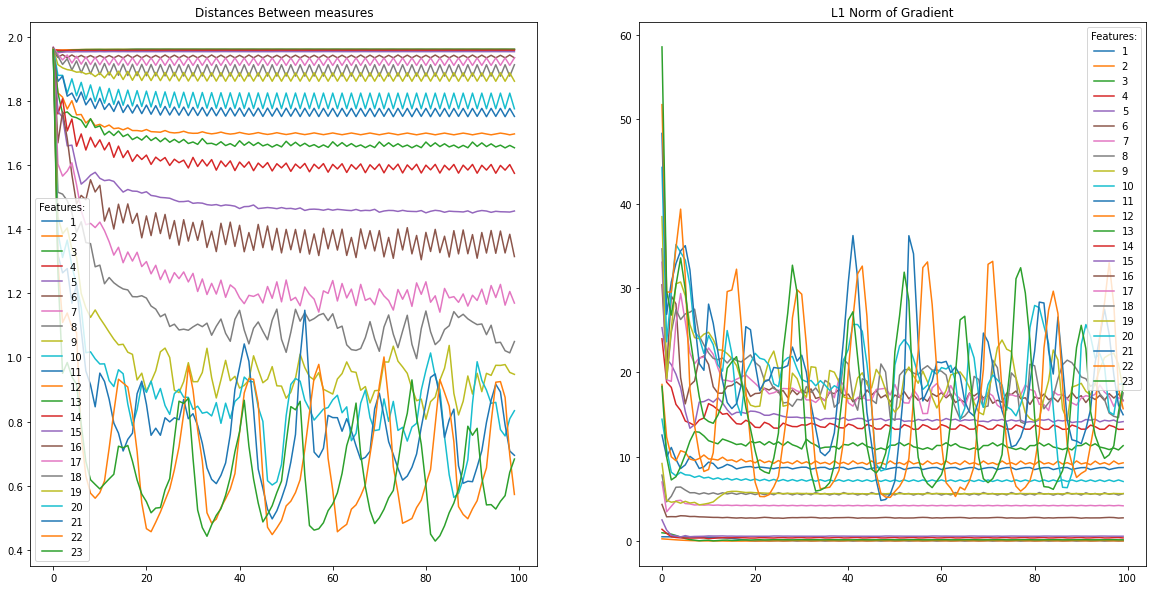

In [99]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all_svd.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")

ax.legend(title='Features:')

ax = plt.subplot(122)

for key, item in history_grad_all_svd.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")

ax.legend(title='Features:')
plt.show()

## Lambda influence

In [100]:
A_all_lambda = {}
history_coefs_all_lambda = {}
history_grad_all_lambda = {} 

for l in np.arange(1, 100, step=5)/100:
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50]
    Y = Y[:50]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, verbose=False, svd_flag=True, l=l)
    A_all_lambda[l] = A
    history_coefs_all_lambda[l] = history_coefs
    history_grad_all_lambda[l] = history_grad

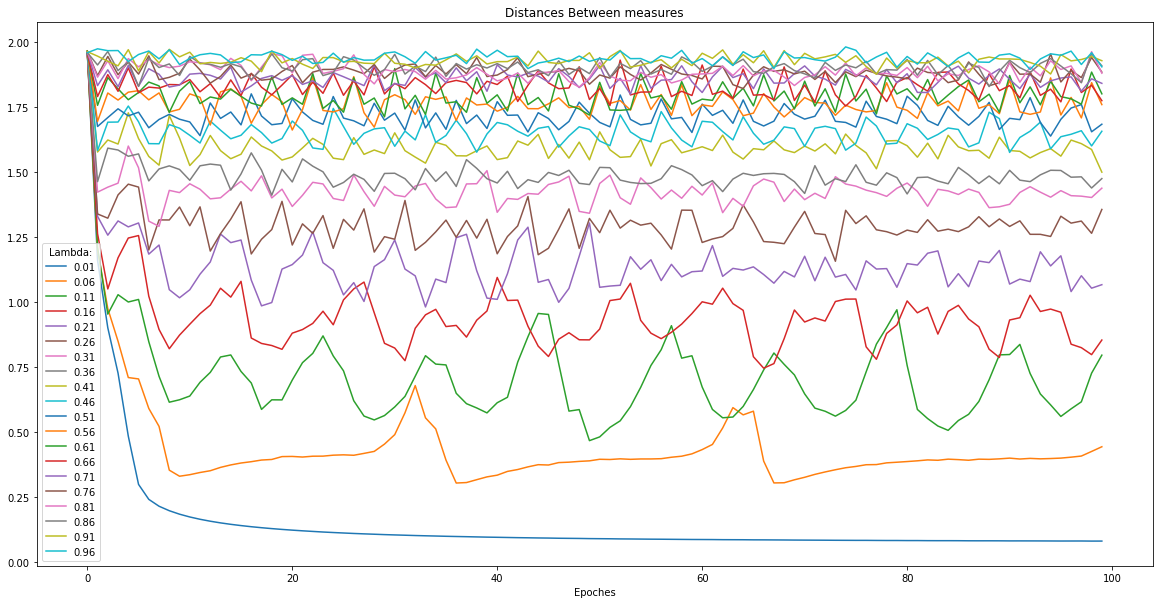

In [101]:
plt.figure(figsize=(20, 10))

for key, item in history_coefs_all_lambda.items():
    plt.plot(item, label=key)
    
plt.title("Distances Between measures")
plt.xlabel("Epoches")
plt.legend(title='Lambda:')
plt.show()

In [102]:
U_o, s_o, V_o = svd(A_all[23])

l2_dist = []
nuclear_norms = []
for key, item in A_all_lambda.items():
    U, s, V = svd(item)
    l2_dist.append(((s_o - s)**2).sum())
    nuclear_norms.append(np.abs(s).sum())

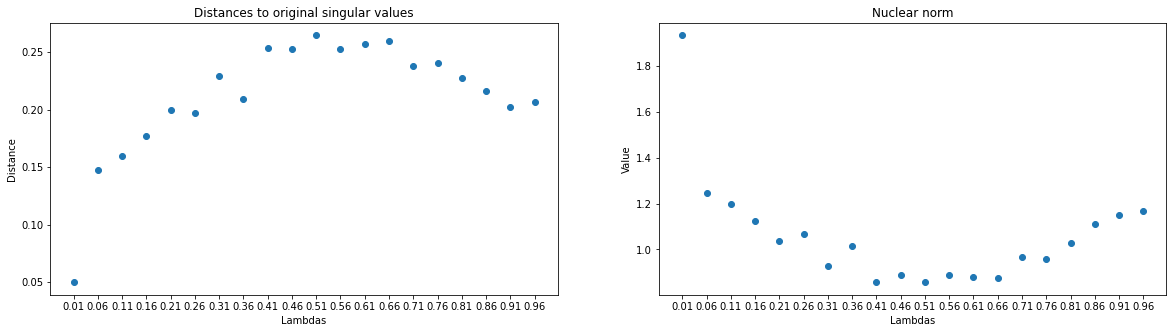

In [103]:
plt.figure(figsize=(20, 5))

ax = plt.subplot(121)
ax.scatter(np.arange(len(A_all_lambda)), l2_dist)
ax.set_title("Distances to original singular values")
ax.set_xlabel("Lambdas")
ax.set_ylabel("Distance")
ax.set_xticks(np.arange(len(A_all_lambda)), labels=A_all_lambda.keys())

ax = plt.subplot(122)
ax.scatter(np.arange(len(A_all_lambda)), nuclear_norms)
ax.set_title("Nuclear norm")
ax.set_xlabel("Lambdas")
ax.set_ylabel("Value")
ax.set_xticks(np.arange(len(A_all_lambda)), labels=A_all_lambda.keys())

plt.show()

## Sigma influence

In [126]:
A_all_sigma = {}
history_coefs_all_sigma = {}
history_grad_all_sigma = {} 

for s in np.arange(5, 200, step=10)/100:
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50]
    Y = Y[:50]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, verbose=False, svd_flag=False, sigma=s)
    A_all_sigma[s] = A
    history_coefs_all_sigma[s] = history_coefs
    history_grad_all_sigma[s] = history_grad

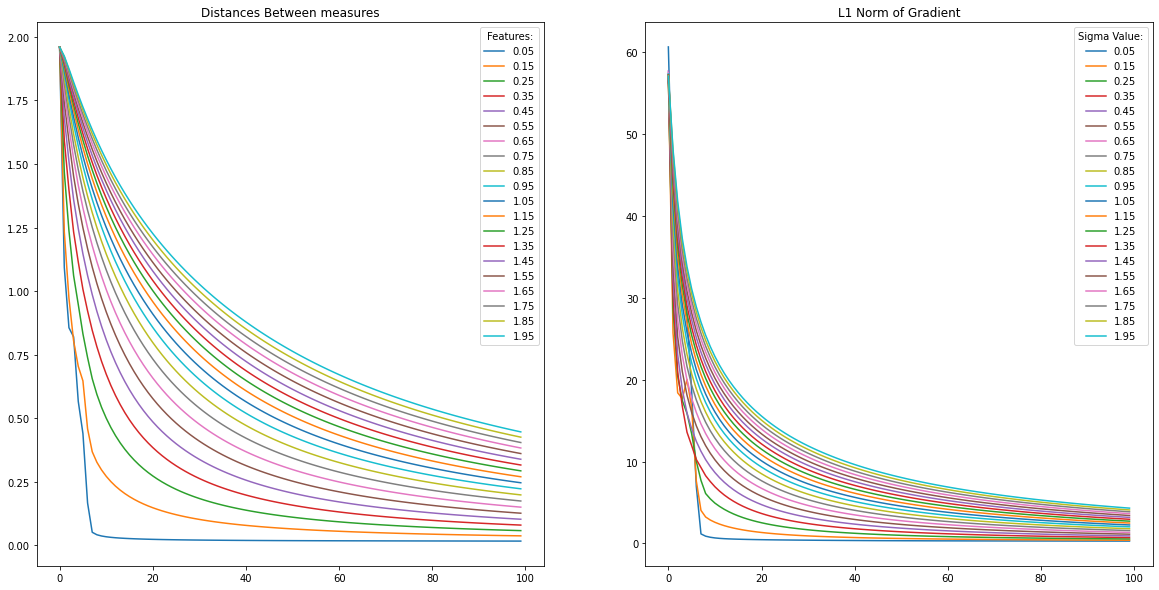

In [127]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all_sigma.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")

ax.legend(title='Features:')

ax = plt.subplot(122)

for key, item in history_grad_all_sigma.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")

ax.legend(title='Sigma Value:')
plt.show()

## Gradient step influence

In [128]:
A_all_step = {}
history_coefs_all_step = {}
history_grad_all_step = {} 

for t in np.arange(5, 100, step=10)/100:
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50]
    Y = Y[:50]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, verbose=False, svd_flag=False, t=t)
    A_all_step[t] = A
    history_coefs_all_step[t] = history_coefs
    history_grad_all_step[t] = history_grad

/Users/FJ6154engie.com/OneDrive - ENGIE/Personal/compress_project/scripts/utils/ot.py:13: RuntimeWarning: overflow encountered in exp
  K = np.exp(Phi/sigma)
/Users/FJ6154engie.com/OneDrive - ENGIE/Personal/compress_project/scripts/utils/ot.py:22: RuntimeWarning: overflow encountered in exp
  return ((np.diag(a).dot(np.exp(Phi/sigma))).dot(np.diag(b)))


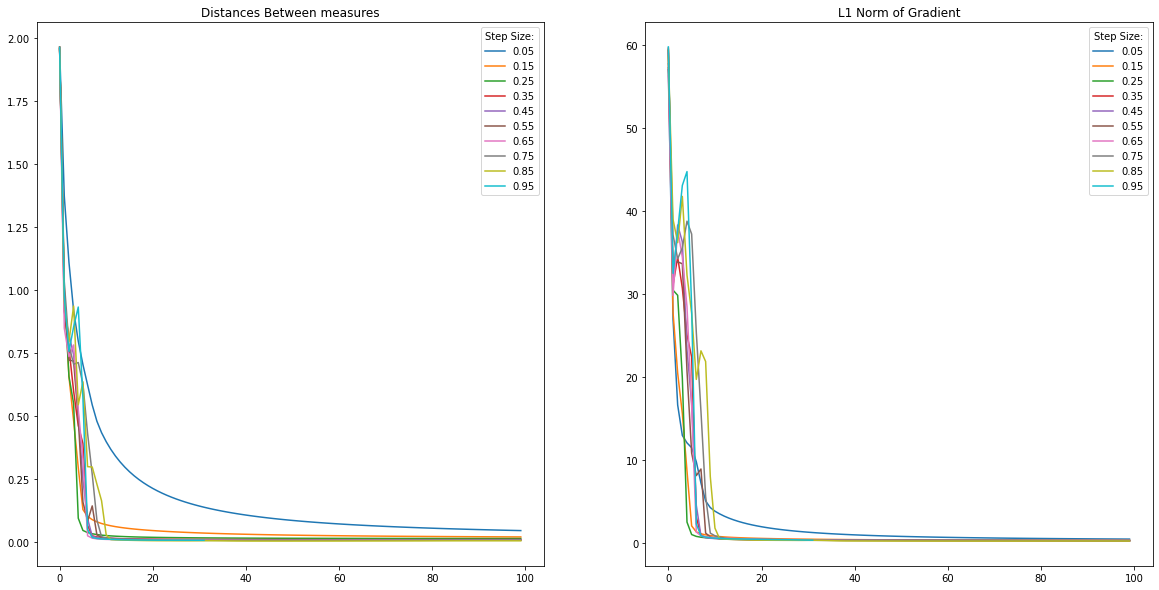

In [129]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all_step.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")

ax.legend(title='Step Size:')

ax = plt.subplot(122)

for key, item in history_grad_all_step.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")

ax.legend(title='Step Size:')
plt.show()